# **Differentiable Wonderland: Chapter 5**
goal: reinforce material from Chapter 5 of Alice's Adventures in a Differentiable Wonderland by implementing PyTorch machine learning workflows. 
- CIFAR10 Image Classifier from Deep Learning with PyTorch: A 60 Minute Blitz
- [choose HuggingFace dataset here]

## **Part 1: Replicating a PyTorch Workflow**

[Deep Learning with PyTorch: A 60 Minute Blitz](https://docs.pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html)

In [58]:
import torch
from torch import nn 
import torch.nn.functional as F 
import numpy as np

import torchvision
from torchvision.models import resnet18, ResNet18_Weights
import torchvision.transforms as transforms

import matplotlib.pyplot as plt 

#### **Tensors**

In mathematics, a tensor refers to an n-dimensional array. Tensors are the general term for mathematical objects such as scalars, vectors, matrices, and any higher-dimensional object. Tensors are the fundamental unit within PyTorch - they are similar to the `np.ndarray`, but can also run on GPUs or other specialized hardware to accelerate computing.

In [13]:
## tensors can be initialized in one of many ways 
data = [[0, 1, 2], [3, 4, 5]]
tensor_data = torch.tensor(data, dtype=torch.int)

np_data = np.array([[1.0, 2.3], [4.5, 6.7]])
tensor_np_data = torch.tensor(np_data, dtype=torch.float)

my_shape = (5, 5, 5)
tensor_ones = torch.ones(my_shape)
tensor_rand = torch.rand(my_shape)
tensor_zero = torch.zeros(my_shape)

In [14]:
## tensors have attributes including shape, type, and storage device 
print(f"Shape of Tensor:  ", tensor_ones.shape)
print(f"Type of Tensor:   ", tensor_ones.dtype)
print(f"Device of Tensor: ", tensor_ones.device)

Shape of Tensor:   torch.Size([5, 5, 5])
Type of Tensor:    torch.float32
Device of Tensor:  cpu


In [22]:
## pytorch supports over 100 different tensor operations! main ones include slicing, indexing, mathematical and linalg operations, etc. 
tensor_ones[:, 1, 1] = 0
combined_tensor_ones = torch.concat([tensor_ones, tensor_ones], axis=0)
element_wise_prod = tensor_data * tensor_data 
matmul_prod = tensor_data @ tensor_data.T

## all in place operations have an underscore suffix 
tensor_data.add_(5)

tensor([[ 5,  8],
        [ 6,  9],
        [ 7, 10]], dtype=torch.int32)

#### **Autograd**

`torch.autograd` is the automatic differentiation engine used by PyTorch to train neural networks. 

Automatic differentiation is a set of techniques used to evaluate the partial derivative of a function specified by a computer program. Differentiation through the use of a computer can typically be performed in one of three ways: 

- Symbolic: manipulation of mathematical expressions to produce exact derivatives. Typically impractical for complex, nested functions present in deep learning. 
- Numeric: approximates derivatives using finite diffences following the formal definition of a derivative (limit as $h\rightarrow 0$). 
- AutoDiff: balances symboic and numeric methods by systematically applying the chain rule to elementary operations and functions. 

[Automatic Differentiation: A Brief Intro with Examples](https://towardsdatascience.com/automatic-differentiation-autodiff-a-brief-intro-with-examples-3f3d257ffe3b/)

Recall that neural network training involves two main stages. Forward propagation directs input forward through the network to generate a prediction. Backward propagation computes the gradient of the loss function with respect to neural network parameters, propagating this gradient backward through the network one layer at a time. The gradient is used to update weight values during an iteration of gradient descent.

In [29]:
## create model + data
model = resnet18(weights=ResNet18_Weights.DEFAULT)
data = torch.rand(1, 3, 64, 64)   # one instance, 3 channels x 64 pixel height x 64 pixel width
labels = torch.rand(1, 1000) 

## forward prop: generate prediction from model 
pred = model(data) 

## backward prop: compute loss, then use it to compute gradient + propagate backward through network 
loss = (pred - labels).sum()
loss.backward() 
optim = torch.optim.SGD(model.parameters(), lr=1e-2, momentum=0.9)      # define optimization algorithm + register model parameters 
optim.step()  # take step in direction of negative gradient, according to optimization algorithm

In [34]:
## how does `autograd` collect gradients? 
a = torch.tensor([2., 3.], requires_grad=True)
b = torch.tensor([6., 4.], requires_grad=True)

f = a**2 + b 

## when we call backward on the function, qutograd calculates the gradients of the function with respect to the inputs, and stores them in the input tensors' grad attribute
f.sum().backward()

print(f"Gradient of a (should be 2a): {a.grad}") 
print(f"Gradient of b (should be 1):    {b.grad}")

Gradient of a (should be 2a): tensor([4., 6.])
Gradient of b (should be 1):    tensor([1., 1.])


Autograd uses a directed acyclic graph (DAG) to track the computations of a network - this is referred to as the computational graph of the network. Autograd uses the DAG to store gradients and propagate them backwards to leaf tensors. Autograd gracks operations on all tensors which have their `requires_grad` parameter set to `True`. Parameters that don't require gradients are called frozen parameters, and are particularly useful in transfer learning applications. Similar functionality can be achieved using the context manager `torch.no_grad()`. 

In [ ]:
model = resnet18(weights=ResNet18_Weights.DEFAULT)

for param in model.parameters(): 
    param.requires_grad = False 

## finetune model on new dataset by re-training final (classifier) layer
model.fc = nn.Linear(512, 10) 
optimizer = optim.SGD(model.parameters(), lr=1e-2, momentum=0.9)

#### **Neural Networks**

The `torch.nn` module is used to construct neural networks, where `nn` depends on `autograd` to define models and differentiate them. 

In [42]:
class Net(nn.Module): 

    def __init__(self): 
        super(Net, self).__init__() 

        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5) 

        self.fc1 = nn.Linear(16 * 5 * 5, 120) 
        self.fc2 = nn.Linear(120, 84) 
        self.fc3 = nn.Linear(84, 10) 

    def forward(self, x): 
        
        ## torch.nn.functional (F) provides stateless versions of functions included in torch.nn, such as max pooling / relu. 
        ## best practice is to apply operations without learnable parameters as stateless within forward method, and operations involving learnable parameters in constructor 

        c1 = F.relu(self.conv1(x)) 
        s2 = F.max_pool2d(c1, (2, 2))

        c3 = F.relu(self.conv2(s2)) 
        s4 = F.max_pool2d(c3, 2)
        s4 = torch.flatten(s4) 

        f5 = F.relu(self.fc1(s4))
        f6 = F.relu(self.fc2(f5)) 

        output = self.fc3(f6) 
        return output 

## instantiate Net object 
model = Net() 
print(model)

## send a random input through the network
x = torch.rand(1, 1, 32, 32) 
pred = model(x) 
print(pred) 

## zero gradient buffers of all parameters 
model.zero_grad()

Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)
tensor([ 0.1240, -0.0502, -0.0246,  0.0376,  0.0214,  0.0218,  0.0901, -0.0148,
        -0.0906,  0.0613], grad_fn=<ViewBackward0>)


In [48]:
## loss fucntion is used to compute some measure of quality based on predictions and ground truth labels 
y = torch.randn(10)
criterion = nn.MSELoss() 

loss = criterion(pred, y) 
print(loss)

## can view computation graph via loss 
print(loss.grad_fn)
print(loss.grad_fn.next_functions[0][0])

tensor(1.5582, grad_fn=<MseLossBackward0>)


In [50]:
## to perform backprop, we need to 1) clear the existing gradients, and 2) call backward on our loss object 
model.zero_grad() 
print(f"conv1.bias.grad before backward: {model.conv1.bias.grad}")

loss.backward() 
print(f"conv1.bias.grad after backward:  {model.conv1.bias.grad}") 

conv1.bias.grad before backward: None
conv1.bias.grad after backward:  tensor([-2.9742e-03,  1.7008e-02,  6.1005e-05, -2.9481e-03,  1.0804e-02,
         3.1006e-03])


In [54]:
## finally, we can update our weights using our chosen optimization algorithm 
optimizer = torch.optim.SGD(model.parameters(), lr=0.01) 

## in training loop... 
optimizer.zero_grad() 
output = model(x) 
loss = criterion(output, y) 
loss.backward() 
optimizer.step() 

#### **Training a Classifier**

Now that we've defined all the setup components required for a neural network, we can actually train a real network on real data. We will train an image classifier on the CIFAR10 dataset.  

Remember that neural network training involves the following key steps: 
1) Load and normalize data (CIFAR10 train + test). 
2) Define network (Convolutional Neural Network).
3) Define a loss function. 
4) Train the network on the training data. 
5) Test the network on the test data. 

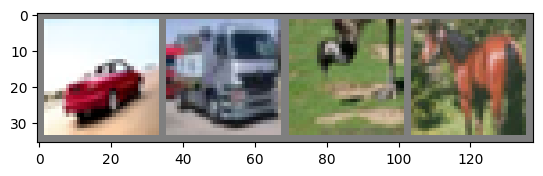

car   truck bird  horse


In [59]:
## step 1: load and normalize CIFAR10 data 
transform = transforms.Compose(
    [transforms.ToTensor(), 
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

batch_size = 4 

train_set = torchvision.datasets.CIFAR10(root="./data", train=True, download=True, transform=transform) 
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)

test_set = torchvision.datasets.CIFAR10(root="./data", train=False, download=True, transform=transform) 
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=True)

classes = ("plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck") 

## display training image (for fun) 
def imshow(img): 
    img = img / 2 + 0.5 
    npimg = img.numpy() 
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show() 

data_iter = iter(train_loader) 
images, labels = next(data_iter) 

imshow(torchvision.utils.make_grid(images)) 
print(" ".join(f"{classes[labels[j]]:5s}" for j in range(batch_size)))

In [68]:
## step 2: define convolutional neural network 
class CNN(nn.Module): 

    def __init__(self): 
        super(CNN, self).__init__() 

        self.conv1 = nn.Conv2d(3, 6, 5) 
        self.pool = nn.MaxPool2d(2, 2) 
        self.conv2 = nn.Conv2d(6, 16, 5) 
        self.fc1 = nn.Linear(16 * 5 * 5, 120) 
        self.fc2 = nn.Linear(120, 84) 
        self.fc3 = nn.Linear(84, 10) 


    def forward(self, x): 

        x = self.pool(F.relu(self.conv1(x))) 
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) 
        x = F.relu(self.fc1(x)) 
        x = F.relu(self.fc2(x)) 
        x = self.fc3(x) 

        return x
    
model = CNN()

In [69]:
## step 3: define loss function + optimizer 
criterion = nn.CrossEntropyLoss() 
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9) 

In [73]:
## step 4: train the network 
for epoch in range(2): 

    running_loss = 0 
    for i, data in enumerate(train_loader, 0): 

        ## get batch of inputs 
        X, y = data 

        ## zero gradients from previous iteration 
        optimizer.zero_grad() 

        ## perform forward pass 
        pred = model(X) 

        ## perform backward pass 
        loss = criterion(pred, y) 
        loss.backward() 
        optimizer.step() 

        ## print statistics 
        running_loss += loss.item() 
        if i % 2000 == 1999:  
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

[1,  2000] loss: 2.147
[1,  4000] loss: 1.832
[1,  6000] loss: 1.642
[1,  8000] loss: 1.557
[1, 10000] loss: 1.492
[1, 12000] loss: 1.434
[2,  2000] loss: 1.366
[2,  4000] loss: 1.350
[2,  6000] loss: 1.311
[2,  8000] loss: 1.278
[2, 10000] loss: 1.287
[2, 12000] loss: 1.254


In [75]:
## step 5: evaluate model on test data 
correct = 0 
total = 0 

with torch.no_grad(): 
    for data in test_loader: 
        X, y = data 
        pred = model(X) 
        _, predicted = torch.max(pred, 1) 
        total += y.size(0) 
        correct += (predicted == y).sum().item()

print(f"Accuracy on Test Set: {100 * correct // total}%")

Accuracy on Test Set: 56%


## **Part 2: Applying PyTorch to a Hugging Face Dataset**

[Working with Hugging Face Datasets](https://huggingface.co/docs/datasets/en/tutorial)